## Jax入坑指南系列(一): Warming up with Jax

### Introduction
在今天的教程里，我们将介绍jax;那什么是jax呢？
我们可以看[jax官方文档](https://jax.readthedocs.io/en/latest/)上的描述:
"JAX is Autograd and XLA, brought together for high-performance numerical computing."
JAX是一个整合Autograd(Autograd: 自动微分)与XLA(accleated linear algerbra:加速线性代数求解器),用于高性能数值计算的计算框架。

XLA是Google开发的用于优化并加速深度学习框架的线性代数编译器，以便在不同的硬件平台(包括 GPU、CPU, TPU加速器)上实现对代码的高性能编译并执行。[XLA官方文档](https://www.tensorflow.org/xla)
Jax把Autograd与XLA这两部分整合在一起，用于高性能数值计算与机器学习等领域的研究与开发。

我们可以将jax当成是一个科学计算库, 类似于python里的科学计算库numpy与scipy,
(注意，请不要直接将jax与其他熟悉的深度学习库pytorch或tensorflow进行类比)。
我们可以以jax为基础, 搭建深度学习中的各类基础模块, 在基础上构建类似pytorch, tensorflow一样的深度学习框架，一个经典的项目是来自google的flex,
[flex github](https://github.com/google/flax)。

### Jax: Quick start
我们先快速列举与一览Jax中的核心概念:
   1. jax的API与numpy非常相似，同时语法也与numpy类似;类似地，Jax有类似scipy的科学计算包jax.scipy。
   2. jax采用函数式编程(functional programming)的范式。
   3. 在jax中，对于随机数生成等场景，我们需要显式地传入伪随机数生成器(PRNG)密钥作为状态量(state or random state)。
   4. 同时我们将介绍jax中常用的变换函数(transform function): jit, grad, vmap, pmap,我们在后续里将经常遇到他们。

In [69]:
# Jax's syntax is (for the most part) same as Numpy's
import jax.numpy as jnp
import numpy as np

#Special transform functions
from jax import grad, jit, vmap, pmap,value_and_grad

#Jax's low-level API 
#lax is just an anagram for XLA, not completely sure how they come up with name JAX
from jax import lax
from jax import make_jaxpr
from jax import random
from jax import device_put
import matplotlib.pyplot as plt

###Testing the backend
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


#### Jax VS numpy 
我们先来看一个简单的三角函数的例子，在数学中我们有$sin(x)cos(x)= (sin(2x))/2$

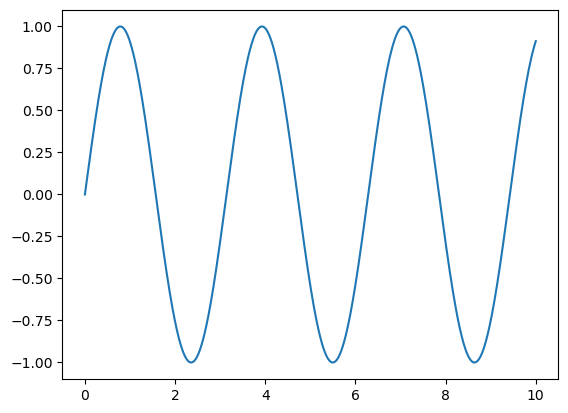

In [70]:
# Fact, jax's syntax is remarkablely similar to numpy
x_np = np.linspace(0,10,1000)
y_np = 2*np.sin(x_np)*np.cos(x_np)
plt.plot(x_np, y_np)

在Jax中，基于jax.numpy

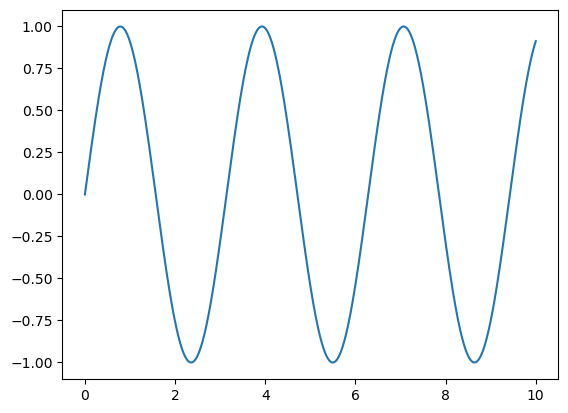

In [71]:
x_jnp = np.linspace(0,10,1000)
y_jnp = 2*jnp.sin(x_jnp)*jnp.cos(x_jnp)
plt.plot(x_jnp, y_jnp)

可以看到，我们可以直接用matplotlib库对jax的结果进行绘图；这在pytorch里是行不通的(我们需要将数据从其所在的backend.device传回至cpu,数据类型从torch.tensor转回至numpy.array)。

### 函数式编程与不变模式(Immutable)
jax采用函数式编程的范式(functional programming paradigm)。众所周知，函数式编程语言和框架的特点之一就是不变模式(immutable): 对于定义好的变量或数组，我们是不能强行改动的(immutable)。
例子: 在numpy与jax.numpy尝试将数组[0 1 2 3 4 5 6 7 8 9]的第一个元素用23替换，将分别得到如下结果:

**Numpy: mutable arrays**:

In [72]:
size = 10;index = 0; value = 23
## numpy, mutable arrays
x = np.arange(size)
print(x)
x[index] = value
print(x)

[0 1 2 3 4 5 6 7 8 9]
[23  1  2  3  4  5  6  7  8  9]


**jax:immutable arrays**:  若在jax中操作会报错并抛出一个typeError("object does not support item assignment.")

In [73]:
##jax ,immutable array
x = jnp.arange(size)
print(x)
x[index] = value
print(x)

[0 1 2 3 4 5 6 7 8 9]


TypeError: '<class 'jaxlib.xla_extension.ArrayImpl'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

**解决方案**: 在jax中,我们需要通过at索引然后进行set操作:

In [74]:
## Solution
y = x.at[index].set(value)
print(x)
print(y)

[0 1 2 3 4 5 6 7 8 9]
[23  1  2  3  4  5  6  7  8  9]


在后台执行逻辑中，jax会在内存中额外创建与分配数组一个新的数据y,也就是会得到两个同时存在的数组x与y。

#### 随机数生成机制
在numpy里，对于如下采样任务: 基于正态分布采样长度为10的1-D array:

In [75]:
x_np = np.random.normal(size=(10,))
x_np

array([-0.65466763,  0.97484409, -0.21256319, -0.67262927, -1.54392598,
       -0.25036153,  0.00908612,  2.6009184 ,  0.89181872, -0.86492052])

在上述的代码里，我们没有显示地定义或传入随机数生成器密钥(PRNG key: pseudo-random number generator key)的动作;但在jax中，对于随机数生成，我们需要显式示(explicitly)传入随机数生成器(PRNG)的密钥(key)作为状态(random state)。
一个jax中基于正态分布采样长度为10的1-D array:

In [9]:
# Fact3 ,jax handles random number differently (for a good reason we will see later)
seed = 0 
key = random.PRNGKey(seed) #显式地传入key
x = random.normal(key, (10,))
print(type(x),x)

<class 'jaxlib.xla_extension.ArrayImpl'> [-0.3721109   0.26423115 -0.18252768 -0.7368197  -0.44030377 -0.1521442
 -0.67135346 -0.5908641   0.73168886  0.5673026 ]


#### AI加速器无关性
我们这里先定义"AI加速器": "AI加速器" (AI accelerator)可以理解为 类似我们在训练AI模型用的设备:CPU,GPU,TPU等等。 在上面的例子里，我们可以看到变量X的类型是deviceArray。jax会自动地将该deviceArray同步至AI加速器上(GPU, TPU)。作者这里举了个例子，他默认用的演示是基于GPU，当其将backend切换至TPU后，jax将自动同步deviceArray至TPU设备上。也就是不需要像pytorch那样，显式地通过to.device操作同步到不同的AI acceleartor。

例子: 矩阵乘以矩阵的转置$A*A^T$, 我们初始化一个3000*3000的矩阵:

In [10]:
## JAX is AI accelerator agnostic.Some code runs everywhere

size = 3000
# Data is automatically pushed into the AI accelerator (Devicearray structure)
# No more need to for ".to.device"(pytorch syntax)
#如果我们是使用GPU作为我们的backend，默认会推送至GPU
x_jnp = random.normal(key, (size,size), dtype=jnp.float32) #我们放弃在GPU里
x_np = np.random.normal(size=(size, size)).astype(np.float32)  # some diff in API exists!
%timeit jnp.dot(x_jnp,x_jnp.T).block_until_ready() # on GPU fast

12.2 ms ± 1.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


numpy的测试(基于cpu的backend),我们可以看到jax相对于numpy的巨大优势:

In [11]:
%timeit np.dot(x_np, x_np.T)  # 2) on CPU - slow (NumPy only works with CPUs)

223 ms ± 1.46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


我们接下来尝试将数据从cpu进转至gpu-device, 然后基于jax的dot product算子进行计算:

In [12]:
%timeit jnp.dot(x_np, x_np.T).block_until_ready()  # 3) on GPU with transfer overhead

38.9 ms ± 950 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


可以看到，由于后台有将数据推送至gpu的开销，我们比之前的纯jax的要慢一些(但依旧比numpy的要快),现在我们直接显式地将数据推送至gpu，然后在基于jax进行dot product:

In [13]:
# Push numpy array explictly to GPU device
x_np_device = device_put(x_np)
%timeit jnp.dot(x_np_device,x_np_device.T).block_until_ready() # same as 1

13.4 ms ± 73.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


1. 在这里我们默认GPU是我们指的AI加速器(AI acceleartor), 在更多场景中，它可以是如google的TPU。
2. 同时，我们在代码里使用block_until_ready: jax内部使用一套异步调度的机制。

### Jax transform function
我们这里主要介绍四类变换函数(transform function):
 1. JIT: 即时编译函数,用来给我们定义的代码或函数进行加速(speeding up your code)。
 2. grad: 用来进行微分(derivatives)或梯度梯度(gradient)计算。
 3. vmap: 用于自动向量化(vectorization)或批处理(batching)。
 4. pmap: 与vmap类似，在不同device之间并行处理。

### JIT即时编译
在jax中，JIT可以对我们写好的函数用XLA进行编译并对编译后的结果进行缓存(cache),在后续执行过程中直接调用缓存结果，从而大幅度提升函数代码的执行速度（jit complie your functions using XLA and cache them）。我们这里以深度学习中的激活函数(activation function)selu 为例, selu激活函数可以表示为: 
$$
\begin{equation*}   selu(x) = \lambda \left\{ \begin{array}{ l l }         x, &\text{if $x>0$} \\         \alpha*e^{x}-\alpha,& \text{if $x \leq 0 $}   \end{array} \right. \end{equation*}\\
$$

In [65]:
### Simple helper visualization function
def visual_func(fn, l=-10, r=10, n=1000):
    x = np.linspace(l,r,n)
    y = fn(x)
    plt.plot(x,y);
    plt.show()

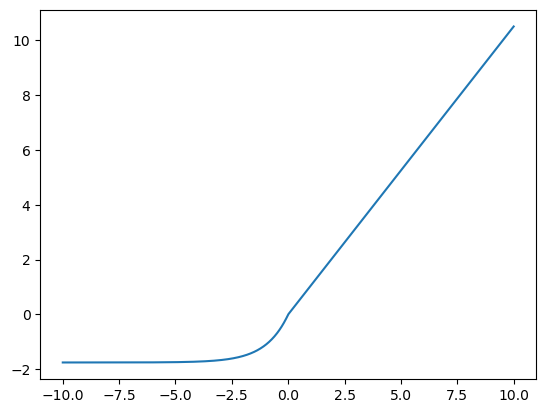

In [66]:
# Define a function, selu is an activation function in DL
def selu(x, alpha=1.67, lmbda=1.05):
    return lmbda*jnp.where(x>0, x, alpha*jnp.exp(x)-alpha)

# 用jit对其进行即时编译:
selu_jit = jit(selu)

##Visualizing selu (just for your understanding)
visual_func(selu)

In [67]:
data = random.normal(key,(100000,))

print("No jit verison")
%timeit selu(data).block_until_ready() 

No jit verison
2.31 ms ± 16.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [68]:
print("jit version")
%timeit selu_jit(data).block_until_ready() 

jit version
405 µs ± 7.66 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


可以看到,经过jit编译后只需要原始1/10不到的时间开销。

### grad：微分计算
在深度学习中,我们模型的底层大规模地依赖自动微分(automatic differentiation)实现神经网络模型的训练, 在jax中主要通过grad函数实现。
假设我们有如下二次函数(quadratic function):
$$
y=f(x_1, x_2, x_3) = x_1^2+x_2^2+z_3^2
$$
在数学上, 对其求偏导(partial derivatives)可得:
$$
\dot{y} = [\frac{\partial y}{\partial x_1}, \frac{\partial y}{\partial x_2},\frac{\partial y}{\partial x_3}] = [2x_1, 2x_2, 2x_3]
$$
若我们取初始点，
$$
x_1=0, x_2=1, x_3=2
$$
我们有:
$$
\dot{y} = [\frac{\partial y}{\partial x_1}, \frac{\partial y}{\partial x_2},\frac{\partial y}{\partial x_3}] = [2x_1, 2x_2, 2x_3]=[0,2,4]
$$
我们用jax对其实现求导:

In [52]:
def sum_square(x):
    return jnp.sum(x**2)

x = jnp.arange(3.)
loss = sum_square # rename it to give it some semantic

grad_loss = grad(loss)
print(grad_loss(x))

[0. 2. 4.]


当然如在神经网络场景里，我们希望同时计算函数的值和其梯度，这时候我们可以使用**value_and_grad**函数进行计算，如对于上述，我们可以有:

In [63]:
x = jnp.arange(3.)
loss = sum_square# rename it to give it some semantic

val, grad = value_and_grad(loss)(x)
print("value", value)
print("gradient",grad)

value 23
gradient [0. 2. 4.]


我们后续将对其梯度及自动微分功能深入展开讨论。

### vmap
**vmap机制**: vmap函数类似于python中的"map-lambda函数"的函数式编程机制, 我们可以通过vmap将一个点的逻辑拓展到整个N维向量。同时，如果我们在实践中将vamp与先前的jit编译机制结合使用，其效率提升效果更佳。

这里举一个例矩阵向量相乘(matrix-vector products)的例子，如我们有一个$150*100$的矩阵，我们可以想象其是神经网络一个layer层的矩阵参数;一个$10*100$,我们可以想象是一个batch,10张图片，每个图片有10*10个向素点。

In [76]:
W = random.normal(key, (150, 100))  # e.g. weights of a linear NN layer
batched_x = random.normal(key, (10, 100))  # e.g. a batch of 10 flattened images

def apply_matrix(x):
    return jnp.dot(W, x)  # (150, 100) * (100, 1) -> (150, 1)

给定上述处理单张图片的逻辑，我们用for-loop循环处理拓展至多张图:

In [77]:
def naively_batched_apply_matrix(batched_x):
    return jnp.stack([apply_matrix(x) for x in batched_x])

print('Naively batched')
%timeit naively_batched_apply_matrix(batched_x).block_until_ready()

Naively batched
7.96 ms ± 154 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


当然，对于多张图的情况，我们可以直接进行多维向量的点乘操作(dot product), 下述对于(150, 100)的参数矩阵与10张图片组成的(10,100)直接dot product:

In [20]:
@jit
def batched_apply_matrix(batched_x):
    return jnp.dot(batched_x, W.T)  # (10, 100) * (100, 150) -> (10, 150)

print('Manually batched')
%timeit batched_apply_matrix(batched_x).block_until_ready()

Manually batched
44 µs ± 5.64 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


在上述中，我们通过直接进行dot product完成了批处理。但在实际更复杂应用中，我们可能很难像上述一样直接dot product的方式进行批处理支持; 类似这样的情况下，我们可以考虑用vamp函数:

In [21]:
@jit  # Note: we can arbitrarily compose JAX transforms! Here jit + vmap.
def vmap_batched_apply_matrix(batched_x):
    return vmap(apply_matrix)(batched_x)
# Task: modify apply_matrix to have 2 inputs and use in_axes arg
print('Auto-vectorized with vmap')
%timeit vmap_batched_apply_matrix(batched_x).block_until_ready()

Auto-vectorized with vmap
50.2 µs ± 5.8 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


在后台逻辑里, vmap会将上述的for-loop打包至lax-api编译，从而获得更好的性能。

**双参数case**: 下面，我们展示如何拓展到多参数函数的场景， 我们这里尝试一个双参数的case: 函数同时包含(W,x)两个参数。当然，这样其实更符合函数式编程的范式:

In [22]:
def apply_matrix(W, x):
    return jnp.dot(W, x)  # (150, 100) * (100, 1) -> (150, 1)

@jit  # Note: we can arbitrarily compose JAX transforms! Here jit + vmap.
def vmap_batched_apply_matrix(W, batched_x):
    return vmap(apply_matrix,in_axes=(None,0))(W, batched_x)
# Task: modify apply_matrix to have 2 inputs and use in_axes arg
print('Auto-vectorized with vmap')
%timeit vmap_batched_apply_matrix(W, batched_x).block_until_ready()

Auto-vectorized with vmap
49.9 µs ± 4.69 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


这里我们使用了in_axes=(None,0),代表:
1. 对于左侧参数矩阵，我们全部参数进行乘法操作。
2. 对于左侧image,我们沿axis=0,即每张图片逐步进行操作。

### Jax: Going deeper 
#### JAX API structure
一个jax的整体框架大体上是如洋葱一般的层次结构, 一层包着一层，从高到低分别是: numpy->lax->xla; lax要比numpy功能更强大但语法上也更严格;同lax是基于xla封装而成的。

如对于两个数想加的操作:在lax里会报错:类型不一致(int vs float)

In [23]:
# Example 1: lax is stricter
print(jnp.add(1, 1.0))  # jax.numpy API implicitly promotes mixed types
print(lax.add(1, 1.0))  # jax.lax API requires explicit type promotion

2.0


TypeError: lax.add requires arguments to have the same dtypes, got int32, float32. (Tip: jnp.add is a similar function that does automatic type promotion on inputs).

In [24]:
print(lax.add(1, 1))  # jax.lax API requires explicit type promotion

2


我们接下看一个深度学习中常见的对两个信号进行卷积(convolution)操作的case:

In [25]:
# Example 2: lax is more powerful (but as a tradeoff less user-friendly)
x = jnp.array([1, 2, 1])
y = jnp.ones(10)

# NumPy API
result1 = jnp.convolve(x, y)

# lax API
result2 = lax.conv_general_dilated(
    x.reshape(1, 1, 3).astype(float),  # note: explicit promotion
    y.reshape(1, 1, 10),
    window_strides=(1,),
    padding=[(len(y) - 1, len(y) - 1)])  # equivalent of padding='full' in NumPy

print(result1)
print(result2[0][0])
assert np.allclose(result1, result2[0][0], atol=1E-6)

# XLA: https://www.tensorflow.org/xla/operation_semantics#convwithgeneralpadding_convolution

[1. 3. 4. 4. 4. 4. 4. 4. 4. 4. 3. 1.]
[1. 3. 4. 4. 4. 4. 4. 4. 4. 4. 3. 1.]


可以看到，在lax里，我们需要把所有的细节都描述清楚,如:
   1. 整理好两个信号tensor的形状(shape)
   2. 定义好stride和paddling的细节。

而在jax.numpy中，我们只需要调用接口模块convolve就可以(按默认参数执行),更为便利。

#### How does JIT actually work?
我们这里展示一个对tensor-array进行正则化(normalization)的例子来进一步分析JIT的工作原理:

In [26]:
# Why JIT? -> jitted functions are much faster.

def norm(X):
    X = X - X.mean(0)
    return X / X.std(0)

In [27]:
norm_compiled = jit(norm)

X = random.normal(key, (10000, 100), dtype=jnp.float32)

assert np.allclose(norm(X), norm_compiled(X), atol=1E-6)

%timeit norm(X).block_until_ready()
%timeit norm_compiled(X).block_until_ready()

350 µs ± 10.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
186 µs ± 550 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


在使用jit的同时，我们需要了解哪些情况下我们jit编译是不可用的；或者什么类型的函数是不能调用jit的;这里我们看一个jit失败的例子:

In [28]:
# Example of a failure: array shapes must be static
def get_negatives(x):
    return x[x < 0]

x = random.normal(key, (10,), dtype=jnp.float32)
print(get_negatives(x))

[-0.3721109  -0.18252768 -0.7368197  -0.44030377 -0.1521442  -0.67135346
 -0.5908641 ]


上述中，矩阵向量的shape必须是静态的(static):对于该函数，我们函数输出的向量长度取决于我们不同的输入向量；这样的在jit编译里里会报错:

In [29]:
print(jit(get_negatives)(x))

NonConcreteBooleanIndexError: Array boolean indices must be concrete; got ShapedArray(bool[10])

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.NonConcreteBooleanIndexError

我们进一步深入探索其内部的工作机制与原理, 这里展示一个矩阵相乘的例子:

In [30]:
# So how does it work in the background? -> tracing on different levels of abstraction
@jit
def f(x, y):
    print("Running f():")
    print(f"  x = {x}")
    print(f"  y = {y}")
    result = jnp.dot(x + 1, y + 1)
    print(f"  result = {result}")
    return result

x = np.random.randn(3, 4)
y = np.random.randn(4)
print(f(x, y))

x2 = np.random.randn(3, 4)
y2 = np.random.randn(4)
print('Second call:')
print(f(x2, y2))  # Oops! Side effects (like print) are not compiled...

Running f():
  x = Traced<ShapedArray(float32[3,4])>with<DynamicJaxprTrace(level=1/0)>
  y = Traced<ShapedArray(float32[4])>with<DynamicJaxprTrace(level=1/0)>
  result = Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=1/0)>
[-0.18846387  1.4169862   2.4689221 ]
Second call:
[3.506858   1.9192804  0.17660007]


1. 在第一次输出结果中，我们看到其打印出x与y的shape;
2. 在第二次的执行中，jax通过 inference: 其与第一次输入和输入shape是一致的，所以其将直接调用在缓存(caching)中编译好的函数进行执行，而print只是函数的side effect; 因此在第二次中，我们将没有看到其打印函数的结果展示。

若我们尝试一个不同shape的，jit将重新编译；因此在下述的结果中，我们又能看到其打印出x与y的shape:

In [31]:
x3 = np.random.randn(3, 5)
y3 = np.random.randn(5)
print('Third call:')
print(f(x3, y3))

Third call:
Running f():
  x = Traced<ShapedArray(float32[3,5])>with<DynamicJaxprTrace(level=1/0)>
  y = Traced<ShapedArray(float32[5])>with<DynamicJaxprTrace(level=1/0)>
  result = Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=1/0)>
[10.414599  9.081685  9.951471]


**Jax expression**: 对于jax的函数，我们可以通过make_jaxpr函数(jax expression)追踪(trace)函数内部的代码逻辑流程;如下述代码所示:

In [32]:
# Same function as above just without the print statements
def f(x, y):
    return jnp.dot(x + 1, y + 1)

print(make_jaxpr(f)(x, y))

{ lambda ; a:f32[3,4] b:f32[4]. let
    c:f32[3,4] = add a 1.0
    d:f32[4] = add b 1.0
    e:f32[3] = dot_general[dimension_numbers=(([1], [0]), ([], []))] c d
  in (e,) }


jit将trace上述的代码逻辑流程并用xla对其进行打包编译，从而进行加速。我们接下来看一个失败的例子:

In [33]:
# 2nd example of a failure:
@jit
def f(x, neg):  # depends on the value - remember tracer cares about shapes and types!
    return -x if neg else x

f(1, True)

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: traced array with shape bool[].
The problem arose with the `bool` function. 
The error occurred while tracing the function f at /tmp/ipykernel_672/2607406635.py:2 for jit. This concrete value was not available in Python because it depends on the value of the argument neg.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

在上述情况中，为了避免错误, 我们可以加上一个静态参数的说明:

In [34]:
# Workaround: the static arguments
from functools import partial
@partial(jit, static_argnums = (1,))
def f(x,neg):
    print(x)
    return -x if neg else x
print(f(1, True))
print(f(2, True))
print(f(2, False))
print(f(23, False))

Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
-1
-2
Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
2
23


而在加上一个静态参数的说明后，jit不会将neg当成是一个抽象对象；而是当成是实际值处理。

### Jax高效编程指南
我们对上述的内容做一个总结，提炼一些高效编程指南list

#### Pure function
pure function机制我们在JIT内部原理中已经讲过;也就是对于同shape和同类型的输入，jax通过jit直接使用caching时编译好的文件:

In [35]:
# Workaround: the "static" arguments
from functools import partial

@partial(jit, static_argnums=(1,))
def f(x, neg):
    print(x)
    return -x if neg else x

print(f(1, True))
print(f(2, True))
print(f(2, False))
print(f(23, False))

Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
-1
-2
Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
2
23


#### 不要尝试在代码中修改全局变量
我们这里展示一些例子:

In [36]:
g = 0.

def impure_uses_globals(x):
    return x + g  # Violating both #1 and #2

# JAX captures the value of the global during the first run
print ("First call: ", jit(impure_uses_globals)(4.))

# Let's update the global!
g = 10.

# Subsequent runs may silently use the cached value of the globals
print ("Second call: ", jit(impure_uses_globals)(5.))

# JAX re-runs the Python function when the type or shape of the argument changes
# This will end up reading the latest value of the global
print ("Third call, different type: ", jit(impure_uses_globals)(jnp.array([4.])))

First call:  4.0
Second call:  5.0
Third call, different type:  [14.]


如对于上述代码，中间我们修改了全局变量；但jax调用caching里的缓存文件执行；应该在中间的第二个case中case并没有生效。
在lax中,迭代器(iterator)是不生效的:

In [37]:
# lax.fori_loop; similarly for lax.scan, lax.cond, etc.
array = jnp.arange(10)
print(lax.fori_loop(0, 10, lambda i,x: x+array[i], 0))  # expected result 45

iterator = iter(range(10))
print(lax.fori_loop(0, 10, lambda i,x: x+next(iterator), 0))  # unexpected result 0

45
0


#### In-Place Updates
jax采取函数式编程的范式，如果我们要对array进行强制修改,我们需要通过索引然后进行set操作。

#### 越界处理: Out-of-Bounds Indexing
在numpy中，如果我们出现如index访问越界 out of bounds, 会抛出异常;在jax中将直接return NaN, 因此在开发过程中我们需要自己注意与处理。下面是numpy与jax.numpy的比较:

In [38]:
try:
  np.arange(10)[11]
except Exception as e:
    print("Exception {}".format(e))

Exception index 11 is out of bounds for axis 0 with size 10


In [39]:
# JAX behavior
# 1) updates at out-of-bounds indices are skipped
# 2) retrievals result in index being clamped
# in general there are currently some bugs so just consider the behavior undefined!

print(jnp.arange(10).at[11].add(23))  # example of 1)
print(jnp.arange(10)[11])  # example of 2)

[0 1 2 3 4 5 6 7 8 9]
9


#### Non-array inputs
在jax中，对于求和等operator算子，我们要求输入是jnp的格式:

In [40]:
try:
    jnp.sum([1, 2, 3])
except TypeError as e:
    print(f"TypeError: {e}")

jnp.sum(jnp.array([1, 2, 3]))

TypeError: sum requires ndarray or scalar arguments, got <class 'list'> at position 0.


Array(6, dtype=int32)

#### random numbers
在jax中，对于随机数生成，我们需要显式地传入状态(state),

In [41]:
# JAX's random functions can't modify PRNG's state!

key = random.PRNGKey(seed)
print(key)  # key defines the state (2 unsigned int32s)

# Let's again sample calling the same function twice
print(random.normal(key, shape=(1,)))
print(key)  # verify that the state hasn't changed

print(random.normal(key, shape=(1,)))  # oops - same results?
print(key)

[0 0]
[-0.20584226]
[0 0]
[-0.20584226]
[0 0]


给定同样的state,我们每次生成的结果是一样的；但如果我们想每一次随机数生成结果不一样。一个常用的trick是我们对key进行split，然后传入:

In [42]:
# Solution? -> Split every time you need a pseudorandom number.
print("old key", key)
key, subkey = random.split(key)
normal_pseudorandom = random.normal(subkey, shape=(1,))
print("    \---SPLIT --> new key   ", key)
print("             \--> new subkey", subkey, "--> normal", normal_pseudorandom)

# Note1: you can also split into more subkeys and not just 1
# Note2: key, subkey no difference it's only a convention

old key [0 0]
    \---SPLIT --> new key    [4146024105  967050713]
             \--> new subkey [2718843009 1272950319] --> normal [-1.2515389]


#### 控制流: Control Flow
我们以如下函数为例, 若直接对其求导；可以直接得到:

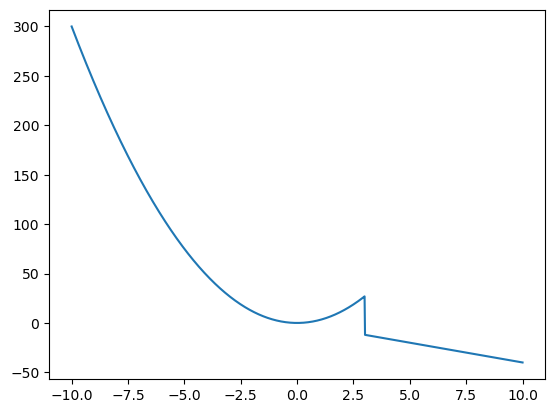

12.0
-4.0


In [43]:
# Python control flow + grad() -> everything is ok
def f(x):
    if x < 3:
        return 3. * x ** 2
    else:
        return -4 * x

x = np.linspace(-10, 10, 1000)
y = [f(el) for el in x]
plt.plot(x, y); plt.show()

print(grad(f)(2.))  # ok!
print(grad(f)(4.))  # ok!

对于该函数，我们同样需要标明静态参数(static argument):

In [44]:
f_jit = jit(f, static_argnums=(0,))
x = 2.

print(make_jaxpr(f_jit, static_argnums=(0,))(x))
print(f_jit(x))

{ lambda ; . let
    a:f32[] = pjit[jaxpr={ lambda ; . let  in (12.0,) } name=f] 
  in (a,) }
12.0


#### NaN 处理
关于jax中nan值的处理,通常jax将直接返回NaN值而不会抛出异常:

In [45]:
jnp.divide(0., 0.)  # the default non-error behavior will simply return a NaN (as usually)

Array(nan, dtype=float32, weak_type=True)

如果我们代码里需要对nan值进行debug或更严格地处理，可以采取如下方式(将抛出异常):

In [46]:
jnp.divide(0., 0.)  # the default non-error behavior will simply return a NaN (as usually)

# If you want to debug where the NaNs are coming from, there are multiple ways
# to do that, here is one:
from jax.config import config
config.update("jax_debug_nans", True)

#### 浮点数精度
jax强制使用float32，单浮点数精度。

In [47]:
# JAX enforces single precision! There are simple ways around it though.

x = random.uniform(key, (1000,), dtype=jnp.float64)
print(x.dtype)

float32
